In [ ]:
!pip install tqdm

## Dataset Formatting - "Message", "Role", "Content" Format

In [ ]:
import json
import pandas as pd
import ast

# === CONFIG ===
# Define the system prompt suitable for the Mental Health domain
SYSTEM_PROMPT = "You are a compassionate mental health assistant who provides supportive, empathetic, and helpful responses."

# === STEP 1: Load dataset ===
input_file = "/content/Synthetic_Data_10k.jsonl"
output_file = "MH_Synthetic.jsonl"
records = []

with open(input_file, "r", encoding="utf-8") as f:
    for i, line in enumerate(f, start=1):
        line = line.strip()
        if not line:  # skip blank lines
            continue
        try:
            # Try strict JSON first
            records.append(json.loads(line))
        except json.JSONDecodeError:
            try:
                # Fallback: parse Python-style dicts (single quotes, etc.)
                parsed = ast.literal_eval(line)
                # Ensure valid JSON output
                records.append(json.loads(json.dumps(parsed)))
            except Exception as e:
                print(f"⚠️ Skipping line {i}, unfixable: {e}")
                continue

print(f"✅ Loaded {len(records)} valid records after repair.")

# === STEP 2: Convert to Llama-3 format ===
converted_records = []
for r in records:
    instruction = r.get("instruction", "").strip()
    user_input = r.get("input", "").strip()
    output = r.get("output", "").strip()

    # Combine instruction + input for user message
    if user_input:
        user_message = f"{instruction}\n{user_input}" if instruction else user_input
    else:
        user_message = instruction

    chat_format = {
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_message},
            {"role": "assistant", "content": output}
        ]
    }
    converted_records.append(chat_format)

# === STEP 3: Save converted dataset ===
with open(output_file, "w", encoding="utf-8") as f:
    for rec in converted_records:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")

print(f"✅ Conversion completed. Saved {len(converted_records)} records to {output_file}")

# === STEP 4: Preview sample ===
print(json.dumps(converted_records[0], indent=2, ensure_ascii=False))

## Parsing Formatted Dataset

In [ ]:
# Colab Dataset Validator for Llama-style chat JSONL
# -------------------------------------------------
# This notebook/script helps validate a jsonl dataset where each line
# is a sample in the "messages" / role / content chat format (Llama-3.2 style).
# It performs streaming checks to detect JSON parse errors, formatting problems,
# corrupt samples, missing or non-string roles/content, odd quoting (single vs double),
# and offers light, reversible fixes and an option to write a cleaned output file.

# Imports and lightweight utility functions
import json
import ast
import re
import io
import os
import sys
from collections import Counter, defaultdict
from typing import Optional, Tuple, Any, Dict, List

# tqdm for progress bar (Colab-friendly)
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **k):
        return x

SMART_QUOTES_MAP = {
    '\u2018': "'",
    '\u2019': "'",
    '\u201c': '"',
    '\u201d': '"',
    '\u2014': '-',
    '\u2013': '-',
}

ALLOWED_ROLES = {"system", "user", "assistant", "tool", "moderator", "bot"}

# %%
# Parsing helpers: robust, multi-step attempts to parse a json-lines line

def replace_smart_quotes(s: str) -> str:
    for k, v in SMART_QUOTES_MAP.items():
        s = s.replace(k, v)
    return s


def detect_single_quote_heavy(s: str) -> bool:
    # Heuristic: many single quotes vs double quotes suggests python-repr-style instead of JSON
    single = s.count("'")
    double = s.count('"')
    # avoid division by zero
    if double == 0:
        return single > 2
    return (single / (double + 1)) > 2


def parse_line_robust(line: str) -> Tuple[Optional[Any], List[str]]:
    """Try multiple parsing strategies; return (obj or None, list_of_parse_notes).

    Strategies attempted (in order):
    - json.loads
    - smart quote replacement + json.loads
    - ast.literal_eval (python literal)
    - heuristic single->double quote conversion on keys
    - fail with the json exception message
    """
    notes = []
    s = line.rstrip("\n")
    if s.strip() == "":
        notes.append("empty_line")
        return None, notes

    # 1) Direct JSON
    try:
        obj = json.loads(s)
        notes.append("json_ok")
        return obj, notes
    except Exception as e_json:
        notes.append(f"json_error:{type(e_json).__name__}:{str(e_json)[:160]}")

    # 2) Smart-quotes fix
    s2 = replace_smart_quotes(s)
    if s2 != s:
        try:
            obj = json.loads(s2)
            notes.append("json_ok_after_smart_quote_replacement")
            return obj, notes
        except Exception as e2:
            notes.append(f"json_error_after_smart_quotes:{type(e2).__name__}:{str(e2)[:160]}")

    # 3) If heavy single quotes, try ast.literal_eval (safe for python literals)
    if detect_single_quote_heavy(s):
        try:
            obj = ast.literal_eval(s)
            notes.append("ast_literal_eval_ok")
            return obj, notes
        except Exception as e_ast:
            notes.append(f"ast_literal_eval_error:{type(e_ast).__name__}:{str(e_ast)[:160]}")

    # 4) Heuristic: replace single-quoted keys with double-quoted ones (limited scope)
    #    This is a conservative regex that targets keys like: 'key': or 'some-key':
    try:
        heur = re.sub(r"(?P<prefix>[\{,\s])'(?P<key>[A-Za-z0-9_\- ]+)'\s*:", r'\g<prefix>"\g<key>":', s)
        heur = replace_smart_quotes(heur)
        obj = json.loads(heur)
        notes.append("json_ok_after_singlekey_heuristic")
        return obj, notes
    except Exception as e_heur:
        notes.append(f"heuristic_error:{type(e_heur).__name__}:{str(e_heur)[:160]}")

    # 5) Give up
    notes.append("parse_failed")
    return None, notes

# %%
# Validation of a parsed sample

def extract_messages_from_sample(obj: Any) -> Tuple[Optional[List[Dict[str, Any]]], List[str]]:
    """Return (messages_list or None, list of issues/warnings)."""
    issues = []
    if obj is None:
        issues.append("null_sample")
        return None, issues

    # If it's a dict and has 'messages' key
    if isinstance(obj, dict):
        if 'messages' in obj:
            messages = obj['messages']
        # Some datasets put the chat directly as a list at top-level in a 'data' key or similar
        elif 'data' in obj and isinstance(obj['data'], list):
            messages = obj['data']
            issues.append("used_data_instead_of_messages")
        # Single-message sample written as {"role":..., "content":...}
        elif 'role' in obj and 'content' in obj:
            messages = [{'role': obj.get('role'), 'content': obj.get('content')}]
            issues.append("single_message_wrapped")
        else:
            # It might be a sample where messages are inside a string: messages: "[...]"
            if 'messages' in obj and isinstance(obj['messages'], str):
                issues.append('messages_is_string')
                messages = None
            else:
                # not the expected form
                issues.append("missing_messages_key")
                return None, issues

    elif isinstance(obj, list):
        messages = obj
    else:
        issues.append("unexpected_top_level_type")
        return None, issues

    if not isinstance(messages, list):
        issues.append("messages_not_a_list")
        return None, issues

    return messages, issues


def validate_messages_list(messages: List[Dict[str, Any]]) -> Tuple[bool, List[str], List[str]]:
    """Check every message's shape; return (is_valid, errors, warnings)."""
    errors = []
    warnings = []

    for i, m in enumerate(messages):
        if not isinstance(m, dict):
            errors.append(f"message_{i}_not_dict")
            continue
        # role
        role = m.get('role')
        if role is None:
            errors.append(f"message_{i}_missing_role")
        else:
            if not isinstance(role, str):
                errors.append(f"message_{i}_role_not_string_type:{type(role).__name__}")
            else:
                if role.strip() == "":
                    warnings.append(f"message_{i}_role_empty")
                # role cleanliness
                if role.lower() not in ALLOWED_ROLES:
                    warnings.append(f"message_{i}_role_unexpected:{role}")
        # content
        content = m.get('content')
        if content is None:
            errors.append(f"message_{i}_missing_content")
        else:
            if isinstance(content, (dict, list)):
                warnings.append(f"message_{i}_content_is_{type(content).__name__}_not_string")
            elif not isinstance(content, str):
                # e.g., numbers, booleans, bytes
                warnings.append(f"message_{i}_content_nonstring_type:{type(content).__name__}")
            else:
                # check emptiness and length
                if content.strip() == "":
                    warnings.append(f"message_{i}_content_empty")
                if len(content) > 200_000:
                    warnings.append(f"message_{i}_content_very_long:{len(content)}")
    return (len(errors) == 0, errors, warnings)

# %%
# Normalization / auto-fixes for simple common issues

def attempt_fix_sample(obj: Any) -> Tuple[Any, List[str]]:
    """Try conservative fixes; return (fixed_obj, notes). Does not do destructive changes.

    Fixes attempted (conservative):
    - If top-level is {'role':..,'content':..} -> wrap into {'messages':[...]}.
    - If messages exists but is a string -> try to parse it as JSON or Python-literal.
    - If any message's content is dict/list -> convert it to a stable JSON string.
    - Normalize role to str and .strip(), lower-cased (but keep original in case user wants different mapping).

    These fixes aim to make the sample parseable/serializable for fine-tuning.
    """
    notes = []
    if obj is None:
        return obj, ["fix_skipped_null"]

    # If top-level dict with role+content
    if isinstance(obj, dict) and 'messages' not in obj and 'role' in obj and 'content' in obj:
        obj = {'messages': [{'role': obj.get('role'), 'content': obj.get('content')}], **{k:v for k,v in obj.items() if k not in ('role','content')}}
        notes.append('wrapped_single_message_into_messages')

    # Now if messages exists and is a string, attempt to parse
    if isinstance(obj, dict) and 'messages' in obj and isinstance(obj['messages'], str):
        mstr = obj['messages']
        parsed, pnotes = parse_line_robust(mstr)
        notes.append('parsed_messages_string:' + ';'.join(pnotes[:3]))
        if parsed is not None and isinstance(parsed, list):
            obj['messages'] = parsed
        else:
            notes.append('could_not_parse_messages_string_keep_original')

    # For list top-level
    if isinstance(obj, list):
        messages = obj
        wrap_back = False
    elif isinstance(obj, dict) and 'messages' in obj:
        messages = obj['messages']
        wrap_back = True
    else:
        return obj, notes

    # Normalize each message
    fixed_messages = []
    for m in messages:
        if not isinstance(m, dict):
            # try to convert tuples or lists like ('user','hi')
            if isinstance(m, (list, tuple)) and len(m) >= 2:
                role = m[0]
                content = m[1]
                m = {'role': role, 'content': content}
                notes.append('tuple_like_message_converted')
            else:
                # keep as-is and mark
                notes.append('message_not_dict_left_untouched')
                fixed_messages.append(m)
                continue
        role = m.get('role')
        content = m.get('content')
        # normalize role
        if role is not None:
            try:
                role_str = str(role).strip()
                # keep original case but also offer lowercased check as a note
                m['role'] = role_str
                if role_str.lower() not in ALLOWED_ROLES:
                    notes.append(f'role_unexpected:{role_str}')
            except Exception:
                notes.append('role_could_not_be_cast_to_str')
        # normalize content
        if isinstance(content, (dict, list)):
            try:
                m['content'] = json.dumps(content, ensure_ascii=False, sort_keys=True)
                notes.append('content_dictconverted_to_jsonstring')
            except Exception:
                notes.append('content_dict_to_string_failed')
        elif content is None:
            # leave None and let validation flag it
            notes.append('content_none_left')
        else:
            # cast bytes to string if necessary
            if isinstance(content, (bytes, bytearray)):
                try:
                    m['content'] = content.decode('utf-8', errors='replace')
                    notes.append('content_bytes_decoded')
                except Exception:
                    m['content'] = str(content)
                    notes.append('content_bytes_str_fallback')
        fixed_messages.append(m)

    if wrap_back:
        obj['messages'] = fixed_messages
        return obj, notes
    else:
        return fixed_messages, notes

# %%
# High-level scanner that streams across a large jsonl, validates, optionally fixes, and writes cleaned output

def scan_jsonl(
    input_path: str,
    max_lines: Optional[int] = None,
    sample_errors_to_store: int = 20,
    auto_fix: bool = False,
    out_clean_path: Optional[str] = None,
):
    """Scan input_path (jsonlines), validate each sample, optionally fix and write clean file.

    Returns a report dict with counts and lists of sample indices for problematic lines.
    """
    report = {
        'input_path': input_path,
        'total_lines': 0,
        'parsed_ok': 0,
        'parse_failed': 0,
        'validated_ok': 0,
        'validated_failed': 0,
        'fixed_and_validated': 0,
        'fixed_but_invalid': 0,
        'errors_examples': [],  # tuples (lineno, reason, line_snippet)
        'warnings_counter': Counter(),
        'parse_notes_counter': Counter(),
        'role_counter': Counter(),
    }

    write_out = out_clean_path is not None
    out_f = None
    if write_out:
        out_f = open(out_clean_path, 'w', encoding='utf-8')

    def record_error(lineno, reason, line):
        if len(report['errors_examples']) < sample_errors_to_store:
            report['errors_examples'].append({'lineno': lineno, 'reason': reason, 'line_snippet': line[:400]})

    with open(input_path, 'r', encoding='utf-8', errors='replace') as f:
        for lineno, raw_line in enumerate(tqdm(f, desc='scanning', unit='lines')):
            if max_lines is not None and lineno >= max_lines:
                break
            report['total_lines'] += 1

            obj, pnotes = parse_line_robust(raw_line)
            for pn in pnotes:
                report['parse_notes_counter'][pn] += 1

            if obj is None:
                report['parse_failed'] += 1
                record_error(lineno, 'parse_failed:'+(';'.join(pnotes)), raw_line)
                continue
            else:
                report['parsed_ok'] += 1

            # Extract messages
            messages, extr_issues = extract_messages_from_sample(obj)
            for it in extr_issues:
                report['parse_notes_counter'][it] += 1

            if messages is None:
                report['validated_failed'] += 1
                record_error(lineno, 'extract_messages_failed:' + ','.join(extr_issues), raw_line)
                # try to fix if requested
                if auto_fix:
                    fixed_obj, notes = attempt_fix_sample(obj)
                    for n in notes:
                        report['parse_notes_counter'][n] += 1
                    messages_fixed, extr2 = extract_messages_from_sample(fixed_obj)
                    if messages_fixed is not None:
                        is_valid, errors, warnings = validate_messages_list(messages_fixed)
                        if is_valid:
                            report['fixed_and_validated'] += 1
                            if write_out:
                                out_f.write(json.dumps({'messages': messages_fixed}, ensure_ascii=False) + '\n')
                            continue
                        else:
                            report['fixed_but_invalid'] += 1
                            record_error(lineno, 'fixed_but_invalid:' + ','.join(errors + warnings), raw_line)
                continue

            # Validate messages
            is_valid, errors, warnings = validate_messages_list(messages)
            for w in warnings:
                report['warnings_counter'][w] += 1
            if is_valid:
                report['validated_ok'] += 1
                # record roles
                for m in messages:
                    r = m.get('role')
                    if isinstance(r, str):
                        report['role_counter'][r.lower()] += 1
                if write_out:
                    # prefer to standardize to {'messages': [...]} form
                    out_f.write(json.dumps({'messages': messages}, ensure_ascii=False) + '\n')
            else:
                report['validated_failed'] += 1
                reason = 'validation_errors:' + ';'.join(errors[:5])
                record_error(lineno, reason, raw_line)
                # attempt fix if requested
                if auto_fix:
                    fixed_obj, notes = attempt_fix_sample(obj)
                    for n in notes:
                        report['parse_notes_counter'][n] += 1
                    # after fix, try to extract messages and validate
                    messages_fixed, extr2 = extract_messages_from_sample(fixed_obj)
                    if messages_fixed is not None:
                        is_valid2, errors2, warnings2 = validate_messages_list(messages_fixed)
                        if is_valid2:
                            report['fixed_and_validated'] += 1
                            if write_out:
                                out_f.write(json.dumps({'messages': messages_fixed}, ensure_ascii=False) + '\n')
                        else:
                            report['fixed_but_invalid'] += 1
                            record_error(lineno, 'postfix_invalid:' + ';'.join(errors2[:5]), raw_line)
                    else:
                        record_error(lineno, 'postfix_extract_failed', raw_line)

    if out_f is not None:
        out_f.close()

    # Summarize counters to plain dicts
    report['warnings_counter'] = dict(report['warnings_counter'])
    report['parse_notes_counter'] = dict(report['parse_notes_counter'])
    report['role_counter'] = dict(report['role_counter'])

    return report

# %%
# Quick helper to pretty-print a short report

def print_report(report: Dict[str, Any], max_examples: int = 10):
    print("\n=== Dataset Validation Report ===")
    print(f"Input: {report.get('input_path')}")
    print(f"Total lines scanned: {report.get('total_lines')}")
    print(f"Parsed OK: {report.get('parsed_ok')}")
    print(f"Parse failed: {report.get('parse_failed')}")
    print(f"Validated OK: {report.get('validated_ok')}")
    print(f"Validated failed: {report.get('validated_failed')}")
    print(f"Auto-fixed and validated: {report.get('fixed_and_validated')}")
    print(f"Fixed but still invalid: {report.get('fixed_but_invalid')}")
    print('\nTop parse notes:')
    for k, v in sorted(report.get('parse_notes_counter', {}).items(), key=lambda x: -x[1])[:10]:
        print(f"  - {k}: {v}")
    print('\nTop warnings:')
    for k, v in sorted(report.get('warnings_counter', {}).items(), key=lambda x: -x[1])[:10]:
        print(f"  - {k}: {v}")
    print('\nRoles summary:')
    for k, v in sorted(report.get('role_counter', {}).items(), key=lambda x: -x[1])[:20]:
        print(f"  - {k}: {v}")

    if report.get('errors_examples'):
        print('\nExample errors (first ones):')
        for ex in report['errors_examples'][:max_examples]:
            print(f"  - line {ex['lineno']}: {ex['reason']} | snippet: {ex['line_snippet']}")
    print('=== End of report ===\n')

# %%
# Example usage cell - upload file in Colab and run scan

input_path = "/content/MH_Synthetic.jsonl"

report = scan_jsonl(input_path, max_lines=None, auto_fix=False, out_clean_path=None)
print_report(report)

# To produce a cleaned output after inspection:
# report2 = scan_jsonl(input_path, auto_fix=True, out_clean_path='/content/data_cleaned.jsonl')
# print_report(report2)

# End of script

## Dataset Preprocessing

In [ ]:
# Cell 0 — Imports & Config
import json
import os
from collections import Counter
from typing import List, Dict, Any
import pandas as pd
import numpy as np
import random
import math
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# Optional visualization
import matplotlib.pyplot as plt

In [ ]:
# === CONFIG ===
INPUT_FILE = "/content/MH_Synthetic.jsonl"
CLEANED_OUTPUT_JSONL = "mental_health_preprocessed.jsonl"
CLEANED_OUTPUT_CSV = "mental_health_preprocessed.csv"
STATS_REPORT_CSV = "mental_health_token_stats.csv"
SAMPLE_PREVIEW_JSON = "mental_health_sample_preview.jsonl"
HIST_TOKENS_PNG = "token_distribution_hist.png"

# Token thresholds (as you requested)
MIN_TOKENS = 300
MAX_TOKENS = 1024

# System prompt default if any records missing system
DEFAULT_SYSTEM_PROMPT = "You are Elixir, a compassionate and caring mental health AI specializing in providing insights and empathetic mental health guidance. Communicate with warmth, empathy, and professionalism while addressing crisis situations with safety."

# Random seed for reproducibility when sampling
RND_SEED = 42
random.seed(RND_SEED)

print("Config loaded. Input file:", INPUT_FILE)

Config loaded. Input file: /content/MH_Synthetic.jsonl


In [ ]:
# Cell 1 — Load converted JSONL and extract columns (system, user, assistant)
def load_jsonl_messages(file_path: str) -> List[Dict[str, Any]]:
    records = []
    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                rec = json.loads(line)
                records.append(rec)
            except json.JSONDecodeError as e:
                print(f"⚠️ Skipping line {i} in converted file — invalid JSON: {e}")
    return records

def extract_roles_into_df(records: List[Dict[str,Any]]) -> pd.DataFrame:
    rows = []
    for i, rec in enumerate(records):
        msgs = rec.get("messages", [])
        # default empty, will fill from roles
        system_text = ""
        user_text = ""
        assistant_text = ""
        for m in msgs:
            r = (m.get("role") or "").lower().strip()
            content = m.get("content") or ""
            if r == "system":
                system_text += ("" if system_text=="" else "\n") + content
            elif r == "user":
                user_text += ("" if user_text=="" else "\n") + content
            elif r == "assistant" or r == "bot":
                assistant_text += ("" if assistant_text=="" else "\n") + content
            else:
                # If other roles present, append to user by default (optional)
                user_text += ("" if user_text=="" else "\n") + content
        rows.append({
            "_orig_index": i,
            "system": system_text,
            "user": user_text,
            "assistant": assistant_text,
            "_raw": rec
        })
    df = pd.DataFrame(rows)
    return df

# Load
records = load_jsonl_messages(INPUT_FILE)
print(f"Loaded {len(records)} raw records from {INPUT_FILE}")

df = extract_roles_into_df(records)
print("Dataframe shape:", df.shape)
# Quick view
df.head(3)

Loaded 8645 raw records from /content/MH_Synthetic.jsonl
Dataframe shape: (8645, 5)


,_orig_index,system,user,assistant,_raw
0,0,"You are Elixir, a supportive AI chatbot design...",I think I might be developing a substance abus...,I'm really glad that you reached out and share...,"{'messages': [{'role': 'system', 'content': 'Y..."
1,1,"You are Elixir, a supportive AI chatbot design...",Parenting has become such a challenge for me. ...,I can understand how challenging parenting can...,"{'messages': [{'role': 'system', 'content': 'Y..."
2,2,"You are Elixir, a supportive AI chatbot design...",Intimacy has always been a struggle for me. I ...,I can understand how challenging it must be fo...,"{'messages': [{'role': 'system', 'content': 'Y..."


In [ ]:
# Cell 2 — Setup tokenizer with fallbacks
def get_token_counter():
    """
    Returns a function count_tokens(text)->int and a name describing which tokenizer used.
    Tries tiktoken.cl100k_base, falls back to transformers AutoTokenizer('gpt2'),
    falls back to simple whitespace split.
    """
    # 1) try tiktoken
    try:
        import tiktoken
        # cl100k_base is a general-purpose encoding used by many modern chat models
        enc = tiktoken.get_encoding("cl100k_base")
        def _count_tokens_tiktoken(text: str) -> int:
            if not isinstance(text, str) or text == "":
                return 0
            return len(enc.encode(text))
        return _count_tokens_tiktoken, "tiktoken(cl100k_base)"
    except Exception as e:
        print("tiktoken not available or failed:", e)

    # 2) try transformers GPT-2 tokenizer as fallback
    try:
        from transformers import AutoTokenizer
        tok = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
        # avoid adding special tokens so counts are conservative
        def _count_tokens_hf(text: str) -> int:
            if not isinstance(text, str) or text == "":
                return 0
            ids = tok.encode(text, add_special_tokens=False)
            return len(ids)
        return _count_tokens_hf, "hf-tokenizer(gpt2)"
    except Exception as e:
        print("transformers tokenizer not available or failed:", e)

    # 3) fallback to whitespace approximation
    def _count_tokens_ws(text: str) -> int:
        if not isinstance(text, str) or text == "":
            return 0
        return max(1, len(text.split()))
    print("Using whitespace-based token approximation (least accurate).")
    return _count_tokens_ws, "whitespace"

count_tokens, tokenizer_name = get_token_counter()
print("Using tokenizer:", tokenizer_name)

Using tokenizer: tiktoken(cl100k_base)


In [ ]:
# Cell 3 — Compute token counts for each column + total and some derived columns
def compute_token_columns(df: pd.DataFrame, count_fn):
    df = df.copy()
    # If system empty, optionally fill with default (or leave empty). We'll keep empty but record count.
    df["system"] = df["system"].fillna("").astype(str)
    df["user"] = df["user"].fillna("").astype(str)
    df["assistant"] = df["assistant"].fillna("").astype(str)

    # Tokenize
    tokens_system = []
    tokens_user = []
    tokens_assistant = []
    for text in tqdm(df["system"].tolist(), desc="tokenizing system"):
        tokens_system.append(count_fn(text))
    for text in tqdm(df["user"].tolist(), desc="tokenizing user"):
        tokens_user.append(count_fn(text))
    for text in tqdm(df["assistant"].tolist(), desc="tokenizing assistant"):
        tokens_assistant.append(count_fn(text))

    df["tokens_system"] = tokens_system
    df["tokens_user"] = tokens_user
    df["tokens_assistant"] = tokens_assistant

    # Totals (including system)
    df["tokens_total"] = df["tokens_system"] + df["tokens_user"] + df["tokens_assistant"]
    # Optional: total without system
    df["tokens_user_assistant"] = df["tokens_user"] + df["tokens_assistant"]
    return df

df = compute_token_columns(df, count_tokens)
print("Token columns computed.")
df[["tokens_system","tokens_user","tokens_assistant","tokens_total","tokens_user_assistant"]].describe().T

tokenizing system:   0%|          | 0/8645 [00:00<?, ?it/s]

tokenizing user:   0%|          | 0/8645 [00:00<?, ?it/s]

tokenizing assistant:   0%|          | 0/8645 [00:00<?, ?it/s]

Token columns computed.


,count,mean,std,min,25%,50%,75%,max
tokens_system,8645.0,45.000000,0.000000,45.0,45.0,45.0,45.0,45.0
tokens_user,8645.0,135.901446,113.224545,2.0,61.0,84.0,202.0,3155.0
tokens_assistant,8645.0,425.898091,73.022233,76.0,376.0,423.0,470.0,1386.0
tokens_total,8645.0,606.799537,158.630199,123.0,499.0,563.0,693.0,3923.0
tokens_user_assistant,8645.0,561.799537,158.630199,78.0,454.0,518.0,648.0,3878.0


In [ ]:
# Cell 4 — EDA: stats per column (mean, median, min, max, percentiles), missing & duplicates
def column_token_stats(df: pd.DataFrame, col: str):
    s = df[col].dropna().astype(int)
    return {
        "count": int(s.count()),
        "mean": float(s.mean()),
        "median": float(s.median()),
        "std": float(s.std()),
        "min": int(s.min()) if len(s)>0 else 0,
        "max": int(s.max()) if len(s)>0 else 0,
        "p01": int(s.quantile(0.01)) if len(s)>0 else 0,
        "p05": int(s.quantile(0.05)) if len(s)>0 else 0,
        "p25": int(s.quantile(0.25)) if len(s)>0 else 0,
        "p75": int(s.quantile(0.75)) if len(s)>0 else 0,
        "p95": int(s.quantile(0.95)) if len(s)>0 else 0,
        "p99": int(s.quantile(0.99)) if len(s)>0 else 0
    }

stats = {
    "tokens_system": column_token_stats(df, "tokens_system"),
    "tokens_user": column_token_stats(df, "tokens_user"),
    "tokens_assistant": column_token_stats(df, "tokens_assistant"),
    "tokens_total": column_token_stats(df, "tokens_total"),
    "tokens_user_assistant": column_token_stats(df, "tokens_user_assistant"),
}
pd.DataFrame(stats).T

,count,mean,median,std,min,max,p01,p05,p25,p75,p95,p99
tokens_system,8645.0,45.000000,45.0,0.000000,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
tokens_user,8645.0,135.901446,84.0,113.224545,2.0,3155.0,34.0,43.0,61.0,202.0,343.0,411.0
tokens_assistant,8645.0,425.898091,423.0,73.022233,76.0,1386.0,281.0,319.0,376.0,470.0,546.0,615.0
tokens_total,8645.0,606.799537,563.0,158.630199,123.0,3923.0,390.0,432.0,499.0,693.0,891.0,1022.0
tokens_user_assistant,8645.0,561.799537,518.0,158.630199,78.0,3878.0,345.0,387.0,454.0,648.0,846.0,977.0


In [ ]:
# Missing values and empty content checks
def missing_and_empty_checks(df: pd.DataFrame):
    res = {}
    res["n_records"] = len(df)
    res["n_missing_system"] = int((df["system"].isna() | (df["system"].str.strip()=="")).sum())
    res["n_missing_user"] = int((df["user"].isna() | (df["user"].str.strip()=="")).sum())
    res["n_missing_assistant"] = int((df["assistant"].isna() | (df["assistant"].str.strip()=="")).sum())
    # rows missing user or assistant
    res["n_missing_user_or_assistant"] = int(((df["user"].str.strip()=="") | (df["assistant"].str.strip()=="")).sum())
    return res

missing_report = missing_and_empty_checks(df)
missing_report

{'n_records': 8645,
 'n_missing_system': 0,
 'n_missing_user': 0,
 'n_missing_assistant': 0,
 'n_missing_user_or_assistant': 0}

In [ ]:
def duplicates_check(df: pd.DataFrame):
    # Ensure all values are strings (convert dicts/lists safely)
    user_str = df["user"].apply(lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, (dict, list)) else str(x))
    assistant_str = df["assistant"].apply(lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, (dict, list)) else str(x))

    # Define duplicate key as user+assistant
    dupe_key = user_str.str.strip().fillna("") + "||" + assistant_str.str.strip().fillna("")

    dup_bool = dupe_key.duplicated(keep=False)
    total_dupes = int(dup_bool.sum())
    unique_dupe_groups = int(dupe_key[dup_bool].nunique())

    # exact duplicates across entire row
    exact_dupe_count = int(df.duplicated(keep=False).sum())

    return {
        "total_duplicates_rows_by_user_assistant": total_dupes,
        "unique_duplicate_groups_by_user_assistant": unique_dupe_groups,
        "exact_duplicate_rows": exact_dupe_count
    }

import json
df = df.applymap(lambda x: json.dumps(x, sort_keys=True) if isinstance(x, dict) else x)

dupe_report = duplicates_check(df)
dupe_report

{'total_duplicates_rows_by_user_assistant': 0,
 'unique_duplicate_groups_by_user_assistant': 0,
 'exact_duplicate_rows': 0}

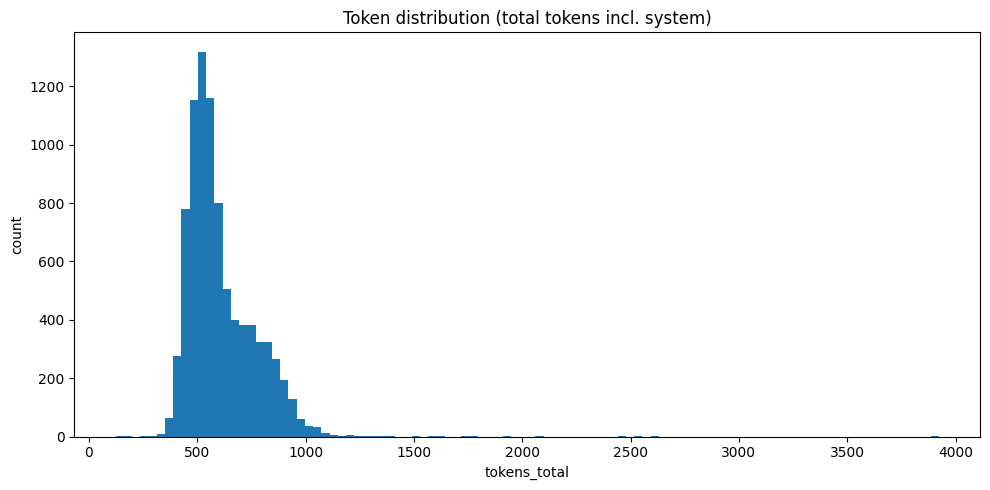

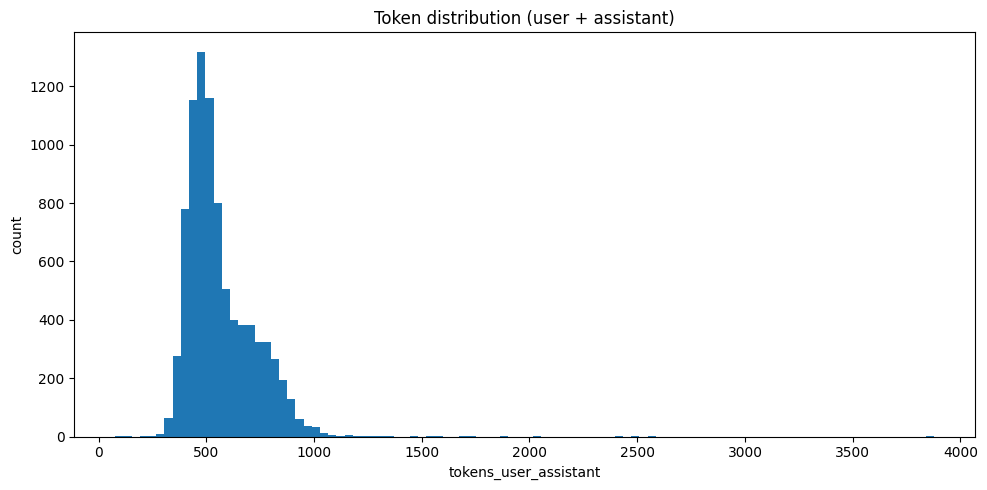

In [ ]:
# Cell 5 — Visualizations: token distributions and saving histograms
plt.figure(figsize=(10,5))
plt.hist(df["tokens_total"], bins=100)
plt.title("Token distribution (total tokens incl. system)")
plt.xlabel("tokens_total")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(HIST_TOKENS_PNG)
plt.show()

# Also hist for user+assistant
plt.figure(figsize=(10,5))
plt.hist(df["tokens_user_assistant"], bins=100)
plt.title("Token distribution (user + assistant)")
plt.xlabel("tokens_user_assistant")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [ ]:
# Cell 6 — Preprocessing steps:
# 1) Remove rows missing user or assistant (you can instead try imputing — but for supervised fine-tuning we drop)
# 2) Drop duplicates (by user+assistant)
# 3) Filter by token thresholds (MIN_TOKENS <= tokens_total <= MAX_TOKENS)
def preprocess_df(df: pd.DataFrame, drop_missing_user_assistant=True, drop_exact_duplicates=True,
                  drop_duplicate_user_assistant=True, min_tokens=MIN_TOKENS, max_tokens=MAX_TOKENS,
                  use_total_including_system=True):
    df = df.copy()
    # 1) drop rows missing user or assistant
    if drop_missing_user_assistant:
        before = len(df)
        df = df[~((df["user"].str.strip()=="") | (df["assistant"].str.strip()==""))].reset_index(drop=True)
        print(f"Dropped {before - len(df)} rows with missing user or assistant")

    # 2) drop exact duplicates of the raw JSON
    if drop_exact_duplicates:
        before = len(df)
        df = df.drop_duplicates(subset=["_raw"], keep="first").reset_index(drop=True)
        print(f"Dropped {before - len(df)} exact duplicate rows")

    # 3) drop duplicates by user+assistant (keep first)
    if drop_duplicate_user_assistant:
        before = len(df)
        dupe_key = (df["user"].str.strip().fillna("") + "||" + df["assistant"].str.strip().fillna(""))
        df["__dupe_key"] = dupe_key
        df = df.drop_duplicates(subset=["__dupe_key"], keep="first").reset_index(drop=True)
        df = df.drop(columns=["__dupe_key"])
        print(f"Dropped {before - len(df)} rows duplicated by user+assistant")

    # 4) filter by token thresholds
    threshold_col = "tokens_total" if use_total_including_system else "tokens_user_assistant"
    before = len(df)
    df = df[(df[threshold_col] >= min_tokens) & (df[threshold_col] <= max_tokens)].reset_index(drop=True)
    print(f"Dropped {before - len(df)} rows outside token range [{min_tokens}, {max_tokens}] based on {threshold_col}")

    return df

df_clean = preprocess_df(df,
                         drop_missing_user_assistant=True,
                         drop_exact_duplicates=True,
                         drop_duplicate_user_assistant=True,
                         min_tokens=MIN_TOKENS, max_tokens=MAX_TOKENS,
                         use_total_including_system=True)

print("Cleaned dataset size:", len(df_clean))

Dropped 0 rows with missing user or assistant
Dropped 0 exact duplicate rows
Dropped 0 rows duplicated by user+assistant
Dropped 93 rows outside token range [300, 1024] based on tokens_total
Cleaned dataset size: 8552


In [ ]:
# Cell 7 — Save cleaned dataset and summary CSV
# Save JSONL in the same messages format as original (so it's ready for training)
with open(CLEANED_OUTPUT_JSONL, "w", encoding="utf-8") as out_f:
    for _, row in df_clean.iterrows():
        # Ensure we keep the original record structure but we may update messages to reflect default system if missing
        rec = row["_raw"].copy()
        # Optionally ensure messages are exactly system->user->assistant (rebuild)
        sys_text = row["system"] if row["system"].strip() else DEFAULT_SYSTEM_PROMPT
        user_text = row["user"]
        assistant_text = row["assistant"]
        rec["messages"] = [
            {"role": "system", "content": sys_text},
            {"role": "user", "content": user_text},
            {"role": "assistant", "content": assistant_text}
        ]
        out_f.write(json.dumps(rec, ensure_ascii=False) + "\n")

# Also save CSV summary with tokens and important metadata
summary_cols = ["_orig_index", "system", "user", "assistant",
                "tokens_system", "tokens_user", "tokens_assistant", "tokens_user_assistant", "tokens_total"]
df_clean[summary_cols].to_csv(CLEANED_OUTPUT_CSV, index=False, encoding="utf-8")

# Save a small preview (random 20 samples)
preview = df_clean.sample(n=min(20, len(df_clean)), random_state=RND_SEED)
with open(SAMPLE_PREVIEW_JSON, "w", encoding="utf-8") as pf:
    for _, r in preview.iterrows():
        pf.write(json.dumps({
            "system": r["system"],
            "user": r["user"],
            "assistant": r["assistant"],
            "tokens_total": int(r["tokens_total"])
        }, ensure_ascii=False) + "\n")

print("Saved cleaned JSONL:", CLEANED_OUTPUT_JSONL)
print("Saved cleaned CSV summary:", CLEANED_OUTPUT_CSV)
print("Saved sample preview:", SAMPLE_PREVIEW_JSON)

Saved cleaned JSONL: mental_health_preprocessed.jsonl
Saved cleaned CSV summary: mental_health_preprocessed.csv
Saved sample preview: mental_health_sample_preview.jsonl


In [ ]:
# Cell 8 — Final checks & reporting
# Reload cleaned JSONL to verify
def verify_jsonl_schema(fp):
    bad = 0
    n = 0
    with open(fp, "r", encoding="utf-8") as f:
        for i, line in enumerate(f, start=1):
            n += 1
            try:
                rec = json.loads(line)
            except Exception as e:
                bad += 1
                print("Bad JSON in cleaned file at line", i, e)
                continue
            msgs = rec.get("messages")
            if not isinstance(msgs, list) or len(msgs) < 3:
                bad += 1
    return n, bad

n_cleaned, n_bad = verify_jsonl_schema(CLEANED_OUTPUT_JSONL)
print(f"Verification: {n_cleaned} lines in cleaned file, {n_bad} failed basic checks")

# Report summary stats to CSV
token_stats_df = pd.DataFrame(stats).T.reset_index().rename(columns={"index":"stat_name"})
token_stats_df.to_csv(STATS_REPORT_CSV, index=False, encoding="utf-8")
print("Saved token stats CSV:", STATS_REPORT_CSV)

# Quick print summary
print("\n===== SUMMARY =====")
print("Original rows loaded:", len(df))
print("Rows after cleaning:", len(df_clean))
print("Missing report (before cleaning):", missing_report)
print("Duplicates report (before cleaning):", dupe_report)
print("Tokenization used:", tokenizer_name)

# Show a few random cleaned samples (console-friendly)
print("\nRandom sample (3 cleaned rows):")
for _, row in df_clean.sample(n=min(3, len(df_clean)), random_state=RND_SEED).iterrows():
    print("----")
    print("tokens_total:", int(row["tokens_total"]))
    print("SYSTEM:", (row["system"][:300] + "...") if len(row["system"])>300 else row["system"])
    print("USER:", (row["user"][:400] + "...") if len(row["user"])>400 else row["user"])
    print("ASSISTANT:", (row["assistant"][:400] + "...") if len(row["assistant"])>400 else row["assistant"])
    # optionally print full raw if needed
print("===== END =====")

Verification: 8552 lines in cleaned file, 0 failed basic checks
Saved token stats CSV: mental_health_token_stats.csv

===== SUMMARY =====
Original rows loaded: 8645
Rows after cleaning: 8552
Missing report (before cleaning): {'n_records': 8645, 'n_missing_system': 0, 'n_missing_user': 0, 'n_missing_assistant': 0, 'n_missing_user_or_assistant': 0}


NameError: name 'dupe_report' is not defined